In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

import torch

from sbi.utils import BoxUniform
from torch.distributions.multivariate_normal import MultivariateNormal


from data.data_generators import SBIGaussian2d
from data.feature_transforms import identity, first_dim_only
from plot import plot_2d_pdf_on_grid, plot_2d_pdf_contours

from nde.flows import construct_maf
from nde.train import train

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D
from diagnostics.quantile_regression import train_qr_algo
from diagnostics.confidence_regions import hpd_region, waldo_confidence_region, waldo_stats

from tqdm import tqdm
import os

In [2]:
B = 100_000
B_PRIME = 10_000
B_DOUBLE_PRIME = 10_000
N_SAMPLES_POSTERIOR = 50_000

PATH_EXPERIMENT = 'saved_experiments/SBIGaussian2d/'

CONFIDENCE_LEVEL = 0.95

## SBI Task: Simulator, Prior and True/Target Posterior 

- Prior (2D): $p(\theta) = \mathcal{U}([-10,10]^2)$
- Simualtor (2D): $p(x\mid \theta) = \mathcal{N}(\theta, \Sigma)$ with $\Sigma = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$

Goal: estimate $p(\theta\mid x_0)$ with $x_0$ an observation.

In [3]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior

# Prior
low_, high_ = -10, 10
prior = BoxUniform(
    low=torch.FloatTensor([low_, low_]), high=torch.FloatTensor([high_, high_])
)

# Data Generator
data_gen = SBIGaussian2d(prior=prior)

# Simulator
simulator = data_gen.simulator

In [4]:
# Observation
filename = PATH_EXPERIMENT + "groundtruth_observation.pkl"
if os.path.exists(filename):
    observation = torch.load(filename)
    theta_true, x_obs = observation["theta_true"], observation["x_obs"]
else:
    theta_true = torch.FloatTensor([1, 1])  # true parameters
    x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
    observation = {"theta_true": theta_true, "x_obs": x_obs}
    torch.save(observation, "groundtruth_observation.pkl")

# True posterior: P(theta|x_0)
true_posterior_pdf = data_gen.true_posterior_pdf(x_obs)


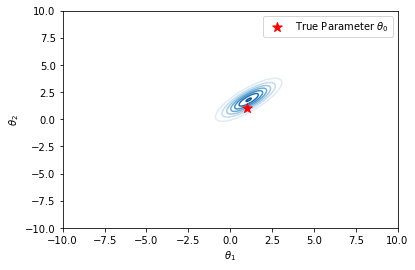

In [6]:
# Plot P(theta|x_0), x_0 ~ simulator(theta_true)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_pdf, low_, high_)
plt.legend()
plt.show()


The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs` and not $\theta_0$=`theta_true`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)/p(x_0) = p(x_0\mid \theta)$ because $p(\theta) \sim \mathcal{U}(0,1)$ is uniform. Finally we have that $p(\theta \mid x_0) = p(x_0\mid \theta) =p_{\mathcal{N}(\theta, \Sigma)}(x_0) = p_{\mathcal{N}(x_0, \Sigma)}(\theta) = \mathcal{N}(x_0, \Sigma)$ because of the symmetry of the gaussian distribution.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation simulated using the true parameter $\theta_0$ to get an empirical approximation of the mean of the simulator likelihood:
$$x_i \sim p(x\mid \theta_0) = \mathcal{N}(\theta_0,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x_i \approx \theta_0$$

So $p(\theta \mid x_{mean}) \approx p(\theta \mid \theta_0) =\mathcal{N}(\theta_0, \Sigma)$.



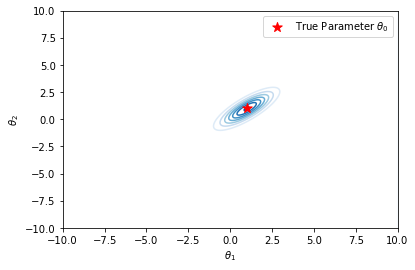

In [8]:
# Plot p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)
x_obs_100 = torch.stack([simulator(theta_true) for i in range(100)])
true_posterior_100_pdf = data_gen.true_posterior_pdf(x_obs_100)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_100_pdf, low_, high_)
plt.legend()
plt.show()

## Data Generation

In [5]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT+'datasets_big.pkl'

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = data_gen.get_joint_data(B_PRIME)
    b_double_prime_theta, b_double_prime_x = data_gen.get_joint_data(B_DOUBLE_PRIME)

    datasets = {
        "B": {'theta':b_theta, 'x':b_x},
        "B_prime": {'theta':b_prime_theta, 'x':b_prime_x},
        "B_double_prime": {'theta':b_double_prime_theta, 'x':b_double_prime_x},
    }
    torch.save(datasets, filename)


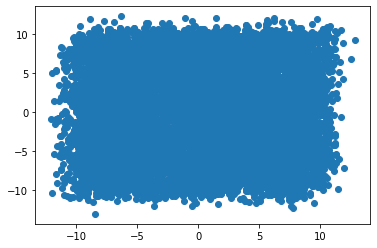

In [6]:
# Simulations Covered Space 
plt.scatter(datasets['B_prime']['x'][:,0], datasets['B_prime']['x'][:,1])


## Train Estimator: NPE (MAF)
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$

In [7]:
# TRAIN/ LOAD TRAINED FLOWS
# Good MAF trained on X=(X_1,X_2)
filename_good = PATH_EXPERIMENT+'maf_good_bigDataset.pkl'

if os.path.exists(filename_good):
    # load flow 
    maf_good = torch.load(filename_good)
else: 
    # define flow
    maf_good = construct_maf(
        datasets['B']['theta'], hidden_features=50, context_features=2, standardize_transform=False
    )
    # train flow
    best_val_loss_good, epochs_good = train(
        maf_good,
        datasets['B']['theta'], # Theta
        context=datasets['B']['x'],  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_good, filename_good)

# Bad MAF trained on g(X) = X_1
filename_bad = PATH_EXPERIMENT+'maf_bad_bigDataset.pkl'

if os.path.exists(filename_bad):
    # load flow
    maf_bad = torch.load(filename_bad)
else: 
    # define flow 
    maf_bad = construct_maf(
        datasets['B']['theta'], hidden_features=50, context_features=1, standardize_transform=False
    )
    # train flow
    best_val_loss_bad, epochs_bad = train(
        maf_bad,
        datasets['B']['theta'], # Theta
        context=first_dim_only(datasets['B']['x']),  # g(X) = X_1
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_bad, filename_bad)


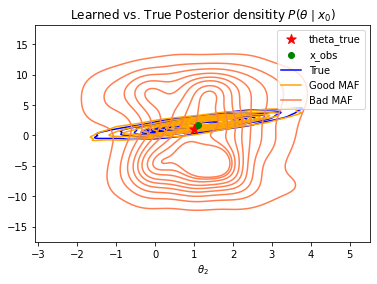

In [8]:
# Plot True vs. learned posteriors: P(theta | x_obs)
true_posterior = data_gen.true_posterior(x_obs)

flows = {
    "Good MAF": (maf_good, x_obs[:][None], "orange"),
    "Bad MAF": (maf_bad, first_dim_only(x_obs[:][None]), "coral"),
}

plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    s=100,
    color="red",
    label="theta_true",
    zorder=3,
)
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plot_2d_pdf_contours(
    true_posterior,
    flows=flows,
    title=r"Learned vs. True Posterior densitity $P(\theta\mid x_0)$",
)


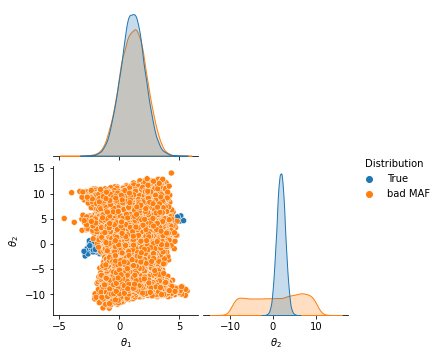

In [9]:
# Pairplot
import pandas as pd
import seaborn as sns
columns = [r"$\theta_1$", r"$\theta_2$"]

samples_true = true_posterior.sample((N_SAMPLES_POSTERIOR,)).numpy()
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples = maf_bad.sample(N_SAMPLES_POSTERIOR, context=first_dim_only(x_obs[:][None]))[0]
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "bad MAF"

dfs = pd.concat([df_true, df_maf], ignore_index=True)

sns.pairplot(dfs, hue="Distribution", corner=True)
plt.show()

## Global vs. Local coverage

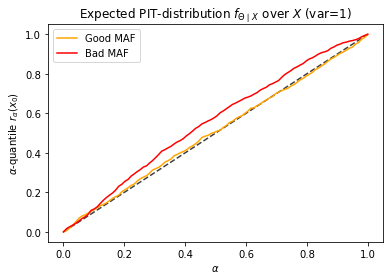

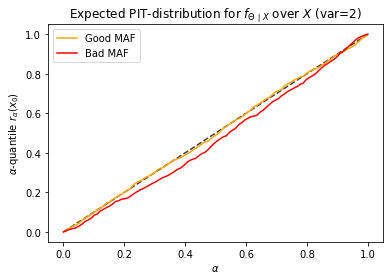

In [26]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = data_gen.get_joint_data(n=1000)

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = multi_cde_pit_values(
    theta_test, x_test, maf_good, feature_transform=identity
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = multi_cde_pit_values(
    theta_test, x_test, maf_bad, feature_transform=first_dim_only
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good[0], flow_joint_pit_values_bad[0]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Expected PIT-distribution $f_{\Theta \mid X}$ over $X$ (var=1)",
)
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good[1], flow_joint_pit_values_bad[1]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$ (var=2)",
)


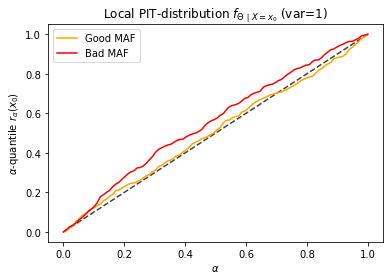

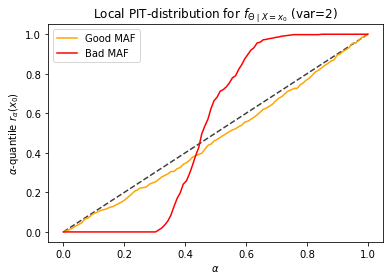

In [33]:
# PLOT LOCAL PIT-DISTRIBUTION of the trained estimators
theta_test_true = true_posterior.sample((500,))

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_0, maf_good) = F_{Q_good|X_0}(Theta_i)]
flow_joint_pit_values_good = multi_cde_pit_values(
    theta_test_true, x_obs[:][None], maf_good, feature_transform=identity, local=True
)
# [PIT(Theta_i, X_0, maf_bad) = F_{Q_bad|X_0}(Theta_i)]
flow_joint_pit_values_bad = multi_cde_pit_values(
    theta_test_true, x_obs[:][None], maf_bad, feature_transform=first_dim_only, local=True
)

# PP-plot of local PIT-distribution for both flows
# alpha-quantiles = [P_Theta|X_0(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good[0], flow_joint_pit_values_bad[0]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution $f_{\Theta \mid X=x_0}$ (var=1)",
)
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good[1], flow_joint_pit_values_bad[1]],
    alphas=np.linspace(0, 1, 100),
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $f_{\Theta \mid X=x_0}$ (var=2)",
)


## Confidence Regions: HPD vs. WALDO

### High Posterior Region: Confidence sets computed directly with the learned posterior

In [34]:
# 2-dimensional grid of (grid_sample_size X grid_sample_size) points
grid_sample_size = 100
param_grid_1d = np.linspace(-10, 10, num=grid_sample_size)
param_grid = np.transpose([np.tile(param_grid_1d, len(param_grid_1d)), np.repeat(param_grid_1d, len(param_grid_1d))])
grid_sample_size = grid_sample_size**2

# observations we whish to evaluate the posterior in
observations = [
    x_obs,  # generated via simulator and theta_true = [1,1]
    torch.FloatTensor([1, 1]),  # for reference = theta_true
    torch.FloatTensor([0, 0]),  # for comparison
    torch.FloatTensor([-1, -1]),  # for comparison
]

In [35]:
# Compute High Posterior Regions
hpd_regions_good = []
hpd_regions_bad = []
actual_confidence_levels_good = []
actual_confidence_levels_bad = []
for i in tqdm(range(len(observations))):
    x = observations[i][None].repeat(grid_sample_size,1)
    current_confidence_level_good, credible_region_good, _ = hpd_region(
        posterior=maf_good,
        prior=None,
        param_grid=torch.FloatTensor(param_grid.astype(np.float32)),
        x=x,
        confidence_level=CONFIDENCE_LEVEL,
        n_p_stars=100_000,
        tol=0.01,
    )
    current_confidence_level_bad, credible_region_bad, _ = hpd_region(
        posterior=maf_bad,
        prior=None,
        param_grid=torch.FloatTensor(param_grid.astype(np.float32)),
        x=first_dim_only(x),
        confidence_level=CONFIDENCE_LEVEL,
        n_p_stars=100_000,
        tol=0.01,
    )
    hpd_regions_good.append(credible_region_good)
    hpd_regions_bad.append(credible_region_bad)
    actual_confidence_levels_good.append(current_confidence_level_good)
    actual_confidence_levels_bad.append(current_confidence_level_bad)


100%|██████████| 4/4 [00:21<00:00,  5.47s/it]


## Calibrated Confidence Regions using WALDO

$\tau^{\text{Waldo}} = (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)^T \Sigma^{-1} (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)$

In [36]:
# Compute Waldo test statistics on data from joint distribution
filename = PATH_EXPERIMENT + "posterior_stats_waldo_bigDataset.pkl"
if os.path.exists(filename):
    posterior_stats_waldo_good = torch.load(filename)
else:
    posterior_stats_waldo_good = []
    for i in tqdm(range(B_PRIME)):
        posterior_samples_qr = maf_good.sample(
            N_SAMPLES_POSTERIOR, context=datasets["B_prime"]["x"][i][None]
        )[0]
        posterior_mean = torch.mean(posterior_samples_qr, dim=0)
        posterior_var = torch.cov(torch.transpose(posterior_samples_qr, 0, 1))
        waldo_stats_i = waldo_stats(
            posterior_mean, posterior_var, param=datasets["B_prime"]["theta"][i, :]
        )
        posterior_stats_waldo.append(waldo_stats_i)
    del posterior_mean, posterior_var

    posterior_stats_waldo_good = np.array(posterior_stats_waldo_good)
    torch.save(posterior_stats_waldo_good, filename)

In [37]:
# Compute Waldo test statistics on data from joint distribution
filename = PATH_EXPERIMENT + "posterior_stats_waldo_bad_bigDataset.pkl"
if os.path.exists(filename):
    posterior_stats_waldo_bad = torch.load(filename)
else:
    posterior_stats_waldo_bad = []
    for i in tqdm(range(B_PRIME)):
        posterior_samples_qr = maf_bad.sample(
            N_SAMPLES_POSTERIOR,
            context=first_dim_only(datasets["B_prime"]["x"][i][None]),
        )[0]
        posterior_mean = torch.mean(posterior_samples_qr, dim=0)
        posterior_var = torch.cov(torch.transpose(posterior_samples_qr, 0, 1))
        waldo_stats_i = waldo_stats(
            posterior_mean, posterior_var, param=datasets["B_prime"]["theta"][i, :]
        )
        posterior_stats_waldo_bad.append(waldo_stats_i)
    del posterior_mean, posterior_var

    posterior_stats_waldo_bad = np.array(posterior_stats_waldo_bad)
    torch.save(posterior_stats_waldo_bad, filename)


In [40]:
# Train quantile regression for critical value prediction
filename = PATH_EXPERIMENT + "waldo_qr_nns.pkl"
if os.path.exists(filename):
    waldo_qr_nns_good = torch.load(filename)
else:
    learner_kwargs = {"epochs": 1000, "batch_size": 50}
    pytorch_kwargs = {"neur_shapes": (128, 128, 128)}
    qr_nn, predicted_cutoffs_nn = train_qr_algo(
        dim=2,
        alpha=CONFIDENCE_LEVEL,
        theta_mat=datasets["B_prime"]["theta"].numpy(),
        stats_mat=posterior_stats_waldo_good,
        learner_kwargs=learner_kwargs,
        pytorch_kwargs=pytorch_kwargs,
        prediction_grid=param_grid,
        nn_dropout=0.0,
    )

    waldo_qr_nns_good = {"qr_nn": qr_nn, "cutoffs_nn": predicted_cutoffs_nn}
    torch.save(waldo_qr_nns_good, "waldo_qr_nns.pkl")


In [38]:
# Train quantile regression for critical value prediction
filename = PATH_EXPERIMENT + "waldo_qr_nns_bad.pkl"
if os.path.exists(filename):
    waldo_qr_nns_bad = torch.load(filename)
else:
    learner_kwargs = {"epochs": 1000, "batch_size": 50}
    pytorch_kwargs = {"neur_shapes": (128, 128, 128)}
    qr_nn, predicted_cutoffs_nn = train_qr_algo(
        dim=2,
        alpha=CONFIDENCE_LEVEL,
        theta_mat=datasets["B_prime"]["theta"].numpy(),
        stats_mat=posterior_stats_waldo_bad,
        learner_kwargs=learner_kwargs,
        pytorch_kwargs=pytorch_kwargs,
        prediction_grid=param_grid,
        nn_dropout=0.0,
    )

    waldo_qr_nns_bad = {"qr_nn": qr_nn, "cutoffs_nn": predicted_cutoffs_nn}
    torch.save(waldo_qr_nns_bad, "waldo_qr_nns_bad.pkl")


100%|██████████| 1000/1000 [02:44<00:00,  6.08it/s]


In [41]:
# Compute calibrated confidence sets with waldo stats and critical values
confidence_sets_good = []
confidence_sets_bad = []
for i in tqdm(range(len(observations)), desc="Computing confidence sets"):
    # sample from learned posterior
    posterior_samples_obs_good = maf_good.sample(
        N_SAMPLES_POSTERIOR, context=observations[i][None]
    )[0]
    posterior_samples_obs_bad = maf_bad.sample(
        N_SAMPLES_POSTERIOR, context=first_dim_only(observations[i][None])
    )[0]
    confidence_sets_good.append(
        waldo_confidence_region(
            posterior_samples=posterior_samples_obs_good,
            critical_values=waldo_qr_nns_good["cutoffs_nn"],
            param_grid=param_grid,
            grid_sample_size=grid_sample_size,
        )
    )
    confidence_sets_bad.append(
        waldo_confidence_region(
            posterior_samples=posterior_samples_obs_bad,
            critical_values=waldo_qr_nns_bad["cutoffs_nn"],
            param_grid=param_grid,
            grid_sample_size=grid_sample_size,
        )
    )



Computing confidence sets: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


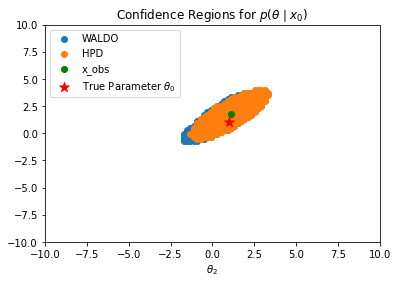

In [42]:
# Plot HPD vs WALDO Confidence Regions 
plt.scatter(confidence_sets_good[0][:, 0], confidence_sets_good[0][:, 1], label='WALDO')
plt.scatter(hpd_regions_good[0][:, 0], hpd_regions_good[0][:, 1], label='HPD')
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    color="red",
    s=100,
    zorder=1,
    label=r"True Parameter $\theta_0$",
)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.title(r'Confidence Regions for $p(\theta \mid x_0)$')
plt.show()


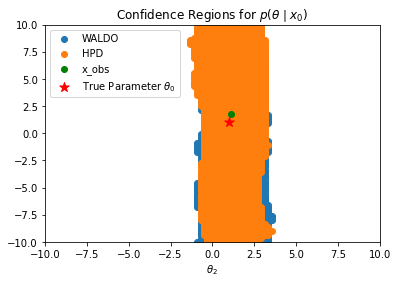

In [45]:
# Plot HPD vs WALDO Confidence Regions 
plt.scatter(confidence_sets_bad[0][:, 0], confidence_sets_bad[0][:, 1], label='WALDO')
plt.scatter(hpd_regions_bad[0][:, 0], hpd_regions_bad[0][:, 1], label='HPD')
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    color="red",
    s=100,
    zorder=1,
    label=r"True Parameter $\theta_0$",
)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.title(r'Confidence Regions for $p(\theta \mid x_0)$')
plt.show()
